In [2]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.regularizers import l2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define the data augmentation and preprocessing pipeline
data_aug = ImageDataGenerator(
    rescale=1./255,                     # Normalize pixel values to [0, 1] range
    horizontal_flip=True,               # Randomly flip images horizontally
    fill_mode='nearest',                # Fill in missing pixels after transformations using nearest neighbor interpolation
)

In [3]:
# Paths to directories
directory = 'C:/Users/psxah20/Desktop/Dissertation/Predictive_Images_Synthetic_Only/'
img_width_height = 224  # Updated to match the paper's input size
batch_size = 224

In [4]:
# Load the training and testing data
train_data = data_aug.flow_from_directory(
    directory + 'Train/',
    target_size=(img_width_height, img_width_height),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    interpolation='nearest',
)

test_data = data_aug.flow_from_directory(
    directory + 'Test/',
    target_size=(img_width_height, img_width_height),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    interpolation='nearest',
)

Found 8861 images belonging to 5 classes.
Found 988 images belonging to 5 classes.


In [5]:
# Define the VGG16-based model with modifications
def build_vgg16_model(input_shape, output_size=6):
    # Load the VGG16 model with pretrained ImageNet weights, excluding the top fully connected layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Unfreeze the last few layers for fine-tuning
    for layer in base_model.layers[:-8]:  # Unfreeze more layers for better fine-tuning
        layer.trainable = False
    for layer in base_model.layers[-8:]:
        layer.trainable = True
    
    # Input layer for full face
    input_full_face = Input(shape=input_shape)
    x_full_face = base_model(input_full_face)
    
    # Add a Global Average Pooling layer
    x = GlobalAveragePooling2D()(x_full_face)
    
    # Define a shallow CNN for further processing with Batch Normalization
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    # Add a softmax output layer
    output = Dense(output_size, activation='softmax')(x)
    
    # Create the final model
    model = Model(inputs=input_full_face, outputs=output)
    
    return model

In [6]:
# Set the input shape and number of classes
img_width_height = 224  # Define image width and height, adjust as necessary
input_shape = (img_width_height, img_width_height, 3)
num_classes = len(train_data.class_indices)

# Build the model
model = build_vgg16_model(input_shape, output_size=num_classes)

# Compile the model with SGD optimizer
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),  # Using momentum to accelerate SGD
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,881,093 (56.77 MB)

 Trainable params: 13,144,837 (50.14 MB)

 Non-trainable params: 1,736,256 (6.62 MB)

In [8]:
# Callbacks for early stopping, learning rate reduction, and model checkpointing
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)
model_checkpoint = ModelCheckpoint('vgg16_best_model.keras', monitor='val_accuracy', save_best_only=True)

In [ ]:
# Fit the model
history = model.fit(
    train_data, 
    epochs=50, 
    validation_data=test_data, 
    callbacks=[early_stop, reduce_lr, model_checkpoint],
    batch_size=32,  # Adjust batch size if needed
    verbose=1
)

In [4]:
metric = pd.DataFrame(model.history.history)
metric

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.652184,2.034895,0.658621,1.391518,0.0010
1,0.710680,1.575040,0.718621,1.236741,0.0010
2,0.755340,1.326667,0.765862,1.089936,0.0010
3,0.790583,1.198719,0.795862,0.905449,0.0010
4,0.825825,1.057255,0.828621,0.817595,0.0010
5,0.856602,0.917202,0.858621,0.756612,0.0010
6,0.875534,0.793995,0.878759,0.693914,0.0002
7,0.887379,0.680227,0.888862,0.657796,0.0002
8,0.897087,0.636753,0.898862,0.634043,0.0002
9,0.904272,0.590269,0.905862,0.646093,0.0002


<Axes: >

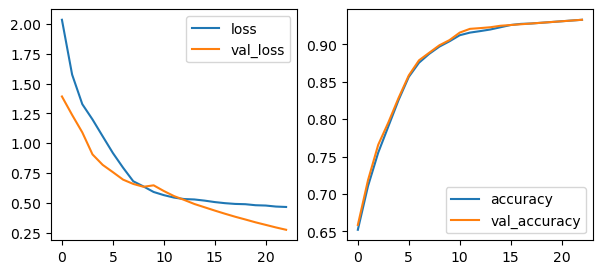

In [5]:
fig, axes = plt.subplots(1,2, figsize=(7,3))
metric[['loss', 'val_loss']].plot(ax=axes[0])
metric[['accuracy', 'val_accuracy']].plot(ax=axes[1])

In [12]:
pred = model.predict(test_data)
pred

3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 10s/step


array([[0.08305141, 0.04461366, 0.02478495, 0.4631784 , 0.29129288,
        0.0930787 ],
       [0.12304687, 0.06332245, 0.06361751, 0.47065017, 0.20485474,
        0.07450822],
       [0.08441158, 0.04566363, 0.02512727, 0.470657  , 0.28337112,
        0.09076947],
       [0.11370443, 0.05536823, 0.05340613, 0.47938326, 0.21878809,
        0.07934985],
       [0.14533918, 0.08235923, 0.08879247, 0.44188106, 0.18103825,
        0.06058986],
       [0.1287802 , 0.06640745, 0.07056539, 0.46203542, 0.20144127,
        0.07077027],
       [0.1344727 , 0.06995055, 0.0752298 , 0.4545053 , 0.19744176,
        0.06839988],
       [0.07747413, 0.04257757, 0.02172665, 0.42888606, 0.32235464,
        0.10698095],
       [0.08246151, 0.04456908, 0.02480392, 0.46334687, 0.29277453,
        0.09204403],
       [0.08766735, 0.04651255, 0.02587343, 0.481928  , 0.27010733,
        0.0879114 ],
       [0.05542885, 0.02118528, 0.01675993, 0.34098318, 0.36913145,
        0.19651133],
       [0.17406519, 0

In [1]:
pred = np.argmax(pred, axis=1)
print(classification_report(test_data.classes, pred))

                Precision Recall  F1-Score  Support
0        pain_1      0.88   0.87      0.87      200
1        pain_2       0.9   0.88      0.89      250
2        pain_3      0.87    0.9      0.88      300
3        pain_4      0.91   0.89      0.90      150
4        pain_5      0.89    0.9      0.89      144
5      Accuracy                       0.89     1044
6     Macro Avg      0.89   0.89      0.89     1044
7  Weighted Avg      0.89   0.89      0.89     1044
